In [ ]:
#!pip install -q tensorflow-gpu==2.0.0-rc1
!pip install tensorflow
!pip3 install 'gast==0.3.3'
import tensorflow as tf

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from scipy.interpolate import splrep, splev

from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import drive
drive.mount('/content/drive')
Folder = '/content/drive/My Drive/Colab Notebooks/2021_OEN/'

Mounted at /content/drive


In [ ]:
fX = Folder + 'saveT_20.csv'
fy = Folder + 'saveL_20.csv'
X = pd.read_csv(fX)
y = pd.read_csv(fy)
print(X.shape, y.shape)
X.head()

(200000, 201) (200000, 8)


,# 400.0,402.0,404.0,406.0,408.0,410.0,412.0,414.0,416.0,418.0,420.0,422.0,424.0,426.0,428.0,430.0,432.0,434.0,436.0,438.0,440.0,442.0,444.0,446.0,448.0,450.0,452.0,454.0,456.0,458.0,460.0,462.0,464.0,466.0,468.0,470.0,472.0,474.0,476.0,478.0,...,722.0,724.0,726.0,728.0,730.0,732.0,734.0,736.0,738.0,740.0,742.0,744.0,746.0,748.0,750.0,752.0,754.0,756.0,758.0,760.0,762.0,764.0,766.0,768.0,770.0,772.0,774.0,776.0,778.0,780.0,782.0,784.0,786.0,788.0,790.0,792.0,794.0,796.0,798.0,800.0
0,0.6780,0.6660,0.6586,0.6555,0.6566,0.6617,0.6708,0.6837,0.7003,0.7204,0.7436,0.7697,0.7982,0.8283,0.8592,0.8899,0.9191,0.9456,0.9680,0.9851,0.9959,1.0000,0.9971,0.9875,0.9720,0.9516,0.9274,0.9005,0.8720,0.8430,0.8143,0.7864,0.7599,0.7350,0.7121,0.6911,0.6722,0.6553,0.6405,0.6275,...,0.4371,0.4363,0.4357,0.4354,0.4354,0.4356,0.4360,0.4367,0.4376,0.4388,0.4402,0.4419,0.4437,0.4459,0.4482,0.4508,0.4536,0.4567,0.4599,0.4634,0.4672,0.4712,0.4754,0.4798,0.4845,0.4894,0.4945,0.4999,0.5055,0.5113,0.5174,0.5236,0.5302,0.5369,0.5439,0.5510,0.5585,0.5661,0.5739,0.5820
1,0.7334,0.7585,0.7866,0.8164,0.8459,0.8727,0.8941,0.9074,0.9106,0.9027,0.8838,0.8553,0.8196,0.7792,0.7368,0.6944,0.6537,0.6158,0.5814,0.5508,0.5240,0.5009,0.4813,0.4651,0.4521,0.4420,0.4347,0.4299,0.4277,0.4278,0.4302,0.4349,0.4418,0.4510,0.4624,0.4761,0.4921,0.5103,0.5307,0.5534,...,0.6041,0.6047,0.6054,0.6060,0.6067,0.6073,0.6079,0.6084,0.6090,0.6095,0.6099,0.6103,0.6107,0.6110,0.6113,0.6115,0.6117,0.6118,0.6120,0.6121,0.6121,0.6121,0.6122,0.6122,0.6122,0.6121,0.6121,0.6121,0.6121,0.6122,0.6122,0.6123,0.6124,0.6126,0.6128,0.6130,0.6133,0.6137,0.6142,0.6147
2,0.7663,0.7835,0.7957,0.8020,0.8022,0.7969,0.7873,0.7749,0.7615,0.7485,0.7372,0.7287,0.7236,0.7223,0.7253,0.7326,0.7442,0.7600,0.7796,0.8025,0.8279,0.8549,0.8819,0.9075,0.9301,0.9478,0.9595,0.9641,0.9615,0.9520,0.9366,0.9166,0.8936,0.8691,0.8444,0.8206,0.7987,0.7791,0.7624,0.7487,...,0.9816,0.9882,0.9930,0.9960,0.9972,0.9965,0.9940,0.9896,0.9836,0.9758,0.9666,0.9560,0.9442,0.9313,0.9175,0.9030,0.8878,0.8723,0.8565,0.8405,0.8244,0.8084,0.7926,0.7769,0.7616,0.7466,0.7320,0.7179,0.7042,0.6910,0.6783,0.6661,0.6544,0.6432,0.6325,0.6224,0.6127,0.6035,0.5948,0.5866
3,0.7972,0.7744,0.7528,0.7322,0.7124,0.6932,0.6745,0.6561,0.6380,0.6203,0.6030,0.5862,0.5700,0.5546,0.5401,0.5267,0.5145,0.5037,0.4943,0.4864,0.4800,0.4753,0.4722,0.4708,0.4712,0.4734,0.4773,0.4831,0.4908,0.5004,0.5120,0.5255,0.5411,0.5586,0.5781,0.5994,0.6224,0.6469,0.6727,0.6992,...,0.7716,0.7722,0.7724,0.7723,0.7719,0.7710,0.7698,0.7682,0.7662,0.7639,0.7612,0.7582,0.7548,0.7512,0.7473,0.7431,0.7387,0.7340,0.7292,0.7242,0.7191,0.7139,0.7086,0.7032,0.6978,0.6923,0.6869,0.6815,0.6761,0.6708,0.6655,0.6604,0.6553,0.6504,0.6455,0.6408,0.6363,0.6319,0.6277,0.6236
4,0.7492,0.7823,0.8179,0.8544,0.8901,0.9231,0.9513,0.9730,0.9874,0.9940,0.9934,0.9867,0.9755,0.9616,0.9465,0.9316,0.9183,0.9073,0.8992,0.8944,0.8930,0.8951,0.9005,0.9088,0.9197,0.9324,0.9463,0.9603,0.9735,0.9846,0.9925,0.9963,0.9952,0.9886,0.9764,0.9591,0.9371,0.9115,0.8831,0.8532,...,0.5982,0.5917,0.5856,0.5800,0.5749,0.5703,0.5661,0.5623,0.5590,0.5560,0.5535,0.5513,0.5495,0.5480,0.5468,0.5460,0.5455,0.5452,0.5452,0.5455,0.5460,0.5467,0.5477,0.5488,0.5501,0.5516,0.5533,0.5551,0.5570,0.5590,0.5611,0.5633,0.5655,0.5678,0.5702,0.5725,0.5748,0.5772,0.5795,0.5817


In [ ]:
features_num = list(X.columns)
preprocessor = make_column_transformer((MinMaxScaler(), features_num),)

y = y.apply(lambda l: (l-40)/160)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)
print(y)

input_shape = [X_train.shape[1]]

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=50,
    restore_best_weights=True,
)

         # L1_1     L1_2     L2_1     L2_2     L3_1     L3_2     L4_1     L4_2
0       0.35625  0.19375  0.28125  0.36250  0.11250  0.53750  0.77500  0.21875
1       0.52500  0.28125  0.91250  0.18750  0.24375  0.65625  0.66250  0.06875
2       0.81875  0.28125  0.95000  0.37500  0.76875  0.70000  0.35000  0.55625
3       0.20000  0.76250  0.08125  0.70000  0.35000  0.73750  0.35000  0.11875
4       0.91250  0.00000  0.63125  0.83750  0.35625  0.45625  0.41875  0.52500
...         ...      ...      ...      ...      ...      ...      ...      ...
199995  0.85625  0.03750  0.63750  0.73125  0.53125  0.26250  0.93125  0.56250
199996  0.31875  0.80000  0.03125  0.93750  0.31875  0.73125  0.70000  0.59375
199997  0.93750  0.77500  0.79375  0.41250  0.78750  0.60000  0.09375  0.08125
199998  0.35000  0.11875  0.06250  0.10000  0.69375  0.10625  0.00000  0.25000
199999  0.93750  0.95625  0.56875  0.47500  0.48125  0.28750  0.40000  0.64375

[200000 rows x 8 columns]


In [ ]:
import keras.backend as K
f_model = keras.models.load_model(Folder + "8L_model_20")
f_model.summary()
def inverse_loss(y_true, y_pred):
  loss = K.mean(K.square(f_model(y_pred) - f_model(y_true)))*100
  return loss

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 300)               2700      
_________________________________________________________________
dense_11 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_12 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_13 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_14 (Dense)             (None, 201)               60501     
Total params: 334,101
Trainable params: 334,101
Non-trainable params: 0
_________________________________________________________________


Model Compile Runtime :  5365.0
Minimum Train Loss : 0.3915 
 Minimum Validation Loss: 0.3807


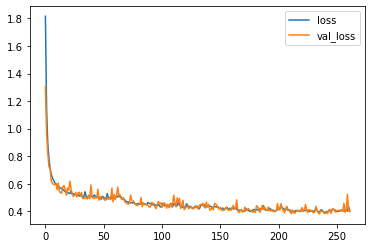

In [ ]:
model = keras.Sequential([
    layers.Dense(200, activation='relu', input_shape=input_shape),
    layers.Dense(500, activation='relu'),
    layers.Dense(200, activation='relu'),
    layers.Dense(20, activation='relu'),
    layers.Dense(8)
])

model.compile(
    optimizer='adam',
    loss=inverse_loss,
)

compile_start = time.time()
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=100,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0,
)
compile_end = time.time()
print("Model Compile Runtime : ", np.round(compile_end - compile_start))

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Train Loss : {:0.4f} \n Minimum Validation Loss: {:0.4f}".format(history_df['loss'].min(), history_df['val_loss'].min()))

In [ ]:
#model.save(Folder + "8L_invmodel_20_Theme_sqloss", save_format='tf')
load_model = keras.models.load_model(Folder + "8L_invmodel_20_Theme_sqloss", custom_objects={'inverse_loss':inverse_loss})
load_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               40400     
_________________________________________________________________
dense_1 (Dense)              (None, 500)               100500    
_________________________________________________________________
dense_2 (Dense)              (None, 200)               100200    
_________________________________________________________________
dense_3 (Dense)              (None, 20)                4020      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 168       
Total params: 245,288
Trainable params: 245,288
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X_RT = pd.read_csv(Folder + 'RTtest_T.csv')
cal_RT = pd.read_csv(Folder + 'RTtest_L.csv')
cal_RT_output = (cal_RT - 40) / 160

predict_start = time.time()
predict_RT_output =  load_model.predict(X_RT)
predict_end = time.time()
predict_RT = np.round(predict_RT_output * 160 + 40)
print("Prediction Runtime : ", np.round(predict_end - predict_start, 2))

Prediction Runtime :  2.14


In [ ]:
X_RT = pd.read_csv(Folder + 'sigma.csv')
predict_RT_output =  load_model.predict(X_RT)
predict_RT = np.round(predict_RT_output * 160 + 40)

In [ ]:
# Material Data
Dict_M = ['Air','Ag','Alq3','C60','CuPC','SiO2','SiNx']
OriginData = np.zeros(7, dtype=object)
OriginData[1] = pd.read_csv(Folder + 'Ag.dat', skipinitialspace=True)  # Ag
OriginData[2] = pd.read_csv(Folder + 'Alq3.dat', skipinitialspace=True)  # Alq3
OriginData[3] = pd.read_csv(Folder + 'c60.dat', skipinitialspace=True)  # c60
OriginData[4] = pd.read_csv(Folder + 'cupc.dat', skipinitialspace=True)  # cupc
OriginData[5] = 1.50  # sio2
OriginData[6] = 1.91  # sinx

Points = 200+1
Lambda = np.linspace(400, 800, Points)  # case 1
j = complex(0, 1)

Index = np.zeros((7, 2, Points))
Index[0][0] = np.full(Points, 1.00)
Index[0][1] = np.zeros(Points)
for i in range(1, 5):
    Index[i][0] = np.array(splev(Lambda, splrep(OriginData[i]['lambda'], OriginData[i]['n'])))
    Index[i][1] = np.array(splev(Lambda, splrep(OriginData[i]['lambda'], OriginData[i]['k'])))
Index[5][0] = np.full(Points, 1.50)
Index[5][1] = np.zeros(Points)
Index[6][0] = np.full(Points, 1.91)
Index[6][1] = np.zeros(Points)

Ksquare = np.zeros((7, Points), dtype=complex)
for i in range(7):
    Ksquare[i] = np.ravel(np.square(np.divide(np.ravel(np.transpose(Index[i]) @ np.array([[1], [j]])), Lambda) * 2*np.pi/(10**-9)))

# Layer conditions
Set_M = np.array([5, 6])  # 0~6 : vacuum, ag, alq3, c60, cupc, sio2, sinx
set_num = len(Set_M)
REP = 4
Data_num = X_RT.shape[0]

def Lm(q, q_next, d):
    Q = np.array([np.array([[(q + q_next) / q_next / 2, (q_next - q) / q_next / 2], [(q_next - q) / q_next / 2, (q + q_next) / q_next / 2]]).swapaxes(0,2), ]*Data_num)
    D = np.multiply(np.eye(2), np.array([np.exp(j * np.outer(q, d).ravel()), np.exp(-j * np.outer(q, d).ravel())]).swapaxes(0, 1)[:, np.newaxis]).reshape(Data_num, Points, 2, 2)
    return Q @ D
vLm = np.vectorize(Lm, otypes=[np.ndarray])

def cal_input(Set_T = np.array(predict_RT)):
    M = np.array([np.identity(2), ]*Data_num*Points).reshape(Data_num, Points, 2, 2)
    q = np.sqrt(np.array(Ksquare[0]))
    q_next = np.sqrt(np.array(Ksquare[Set_M[0]]))
    M = np.matmul(Lm(np.ravel([q]), np.ravel([q_next]), np.ravel([0,]*Data_num)), M)
    q = q_next
    for i in range(1, set_num*REP):
        q_next = np.sqrt(np.array(Ksquare[Set_M[i % set_num]]))
        M = np.matmul(Lm(np.ravel([q]), np.ravel([q_next]), np.ravel(Set_T.transpose()[i-1]*(10**-9))), M)
        q = q_next
    q_next = np.sqrt(np.array(Ksquare[0]))
    M = np.matmul(Lm(np.ravel([q]), np.ravel([q_next]), np.ravel(Set_T.transpose()[set_num*REP-1]*(10**-9))), M)
    M = np.reshape(M, (Data_num*Points, 4)).transpose()
    r, t = -M[2]/M[3], M[0]-M[1]*M[2]/M[3]
    R, T = np.reshape(abs(r)**2, (Points, Data_num)).transpose(), np.reshape(abs(t)**2, (Points, Data_num)).transpose()
    T = np.round(T, 4)
    return T

predict_RT_cal = cal_input()

T Loss :  0.1003


Predicted Layer thickness :  [119. 123. 101. 229. 102. 103.  25. 114.]
T Loss of Example:  0.0758


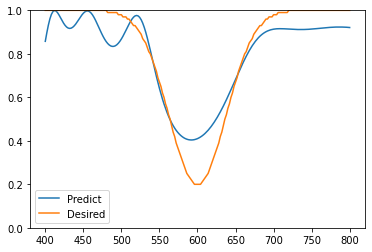

In [ ]:
idx = 1
predict_ex = predict_RT_cal[idx]
cal_ex = np.array(X_RT)[idx]
#print("(Scaled) Test Loss : ", np.round(np.average(np.abs(predict_RT_output - cal_RT_output)), 4))
print("T Loss : ", np.round(np.average(np.abs(predict_RT_cal - X_RT)), 4))
print("\n")
#print("Correct Layer thickness : ", np.array(cal_RT)[idx])
print("Predicted Layer thickness : ", predict_RT[idx])
plt.plot(Lambda, predict_ex.reshape(Points,), label='Predict')
plt.plot(Lambda, cal_ex.reshape(Points,), label='Desired')
plt.ylim(0.0, 1.0)
plt.legend()
print("T Loss of Example: ", np.round(np.average(np.abs(predict_ex - cal_ex)), 4))

T Loss :  0.0999
Predicted Layer thickness :  [ 96. 108. 121. 229. 111.  86.  80.  77.]
T Loss of Example:  0.1296
T Loss :  0.0999
Predicted Layer thickness :  [119. 123. 101. 229. 102. 103.  25. 114.]
T Loss of Example:  0.0754
T Loss :  0.0999
Predicted Layer thickness :  [ 91. 153. 106. 105. 265. 129. -15. 124.]
T Loss of Example:  0.0946


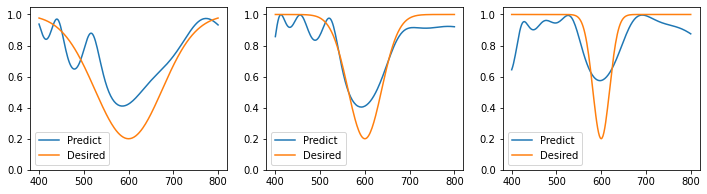

In [ ]:
plt.figure(figsize=(12, 3))
for idx in range(3):
  predict_ex = predict_RT_cal[idx]
  cal_ex = np.array(X_RT)[idx]
  plt.subplot(1, 3, idx+1)
  print("T Loss : ", np.round(np.average(np.abs(predict_RT_cal - X_RT)), 4))
  print("Predicted Layer thickness : ", predict_RT[idx])
  plt.plot(Lambda, predict_ex.reshape(Points,), label='Predict')
  plt.plot(Lambda, cal_ex.reshape(Points,), label='Desired')
  plt.ylim(0.0, 1.05)
  plt.legend()
  print("T Loss of Example: ", np.round(np.average(np.abs(predict_ex - cal_ex)), 4))